# Exploratory NLP on chat messages in pilot data


-------------------------
Spacy lemmatizer, numbers to text

Calculate new column (prop of L specifc over all words in rep)

Proportion of "L" specific words in LP and LC (i.e. changing the denominator to only be towersets with L) -- then average for each dyad across the two towers

Also column for raw count of L specifc words

plot histogram of differences between rep 0 and rep 3



In [33]:
#!pip install spacy

## Import packages

In [1]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from collections import Counter
from num2words import num2words
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import matutils, models
import matplotlib.pyplot as plt
import spacy

import nltk
import os
import string
import numpy as np
import copy
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
import pickle
import re
import math


stemmer = SnowballStemmer("english")

## Import data frames (generated in DF_generator script from mongoDB)

In [2]:
df_chat = pd.read_csv('df_chat.csv')
print(df_chat.shape)
print("Dyads:",len(df_chat.gameid.unique()))

(3066, 21)
Dyads: 71


### Check exclusion criteria

In [3]:
df_trial = pd.read_csv('df_trial.csv')
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

#delete rows that aren't greater than 75% in 9 trials
df75 = df75[df75['trials']>=9]

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 48


### Remove dyads that did not pass exclusion criteria

In [4]:
keep_id = df75.index.tolist()
keep_id
df = df_chat[df_chat['gameid'].isin(keep_id)]
print(df.shape)
print("Passed Dyads:",len(df.gameid.unique()))

(2223, 21)
Passed Dyads: 48


In [5]:
df = df[['gameid','repNum','content','trialNum', 'leftTarget', 'rightTarget']]
df = df[df.trialNum != 'practice']
df = df[df.repNum != 'practice']
df['repNum'] = df['repNum'].astype(int)
df['C'] = (df['leftTarget'] + df['rightTarget']).apply(lambda x: 1 if 'C' in x   else 0)
df['L'] = (df['leftTarget'] + df['rightTarget']).apply(lambda x: 1 if 'L' in x   else 0)
df['P'] = (df['leftTarget'] + df['rightTarget']).apply(lambda x: 1 if 'Pi' in x   else 0)
df = df.drop(['leftTarget', 'rightTarget'],axis = 1)
df.head(2)


,gameid,repNum,content,trialNum,C,L,P
2,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,put a blue block three from the left~~~,0,1,0,1
3,1494-029e2297-bd3f-4cfe-be00-d06d36724e4e,0,place a red block on top of the left side of the blue block and then another red on top of that red,0,1,0,1


## Create Bag of Words for each repNum by concatenating content
create df with column for repnum and column for entire string grouped by repnum

In [6]:
# df['BOW'] = df[['repNum','C','L','Pi','content']].groupby(['repNum','C','L','Pi'])['content'].transform(lambda x: ' '.join(x))
# df = df[['repNum','C','L','Pi','BOW']]
df = df.groupby(['gameid','repNum','C','L','P'])['content'].apply(lambda x: ' '.join(x)).reset_index()

print(df.shape)
df.head(2)

(576, 6)


,gameid,repNum,C,L,P,content
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,1,1,"two blue blocks on left and right side of left right line two red block on top of left blue block just placed down two red block one space apart on right line one blue block on top red block on left red line, on more red block on top of left red block"
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,1,0,1,"for left red line, place blue block in the middle then stack two red on left side of that blue block for left red line, place blue block on highest red so it stick out on the right side for right red line, place one red block two space away from that line, same as step 3, but on the left side, so there is two spaces apart between those two red blocks for right red line, place one blue block on top of each red block so the blue blocks meet/touch"


### Remove stopwords and punctuation

In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['BOW_clean'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [8]:
df['BOW_clean'] = df['BOW_clean'].str.lower()
df['BOW_clean'] = df['BOW_clean'].str.replace(r'~', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\(', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\)', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'\,', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"\'", '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"\:", '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r'"', '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"-", '')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"/", ' ')
df['BOW_clean'] = df['BOW_clean'].str.replace(r".", ' ')
df['BOW_clean'] = df['BOW_clean'].str.replace(r"!", ' ')

## Convert numbers to words

In [9]:
import num2words
from num2words import num2words
def num_2_words(sentence):
    out = ""
    for word in sentence.split():
        try:
            o = num2words(word)
        except:
            o = word
        out = out+" "+ o
    return out

    

In [10]:
df['BOW_clean'] = df['BOW_clean'].apply(lambda x: num_2_words(x))
df.head(2)

,gameid,repNum,C,L,P,content,BOW_clean
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,1,1,"two blue blocks on left and right side of left right line two red block on top of left blue block just placed down two red block one space apart on right line one blue block on top red block on left red line, on more red block on top of left red block",two blue blocks left right side left right line two red block top left blue block placed two red block one space apart right line one blue block top red block left red line red block top left red block
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,1,0,1,"for left red line, place blue block in the middle then stack two red on left side of that blue block for left red line, place blue block on highest red so it stick out on the right side for right red line, place one red block two space away from that line, same as step 3, but on the left side, so there is two spaces apart between those two red blocks for right red line, place one blue block on top of each red block so the blue blocks meet/touch",left red line place blue block middle stack two red left side blue block left red line place blue block highest red stick right side right red line place one red block two space away line step three left side two spaces apart two red blocks right red line place one blue block top red block blue blocks meet touch


In [11]:
# # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
# nlp = spacy.load('en', disable=['parser', 'ner'])

# sentence = "The striped bats are hanging on their feet for best"

# # Parse the sentence using the loaded 'en' model object `nlp`
# doc = nlp(sentence)

# # Extract the lemma for each token and join
# " ".join([token.lemma_ for token in doc]).split()

In [12]:
# df['BOW_lemmatized'] = df['BOW_clean'].apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]).split())


In [13]:
import nltk
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]
df['BOW_lemmatized'] = df['BOW_clean'].apply(lemmatize_text)
print(df.shape)
df.head(3)

(576, 8)


,gameid,repNum,C,L,P,content,BOW_clean,BOW_lemmatized
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,0,1,1,"two blue blocks on left and right side of left right line two red block on top of left blue block just placed down two red block one space apart on right line one blue block on top red block on left red line, on more red block on top of left red block",two blue blocks left right side left right line two red block top left blue block placed two red block one space apart right line one blue block top red block left red line red block top left red block,"[two, blue, block, left, right, side, left, right, line, two, red, block, top, left, blue, block, placed, two, red, block, one, space, apart, right, line, one, blue, block, top, red, block, left, red, line, red, block, top, left, red, block]"
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,1,0,1,"for left red line, place blue block in the middle then stack two red on left side of that blue block for left red line, place blue block on highest red so it stick out on the right side for right red line, place one red block two space away from that line, same as step 3, but on the left side, so there is two spaces apart between those two red blocks for right red line, place one blue block on top of each red block so the blue blocks meet/touch",left red line place blue block middle stack two red left side blue block left red line place blue block highest red stick right side right red line place one red block two space away line step three left side two spaces apart two red blocks right red line place one blue block top red block blue blocks meet touch,"[left, red, line, place, blue, block, middle, stack, two, red, left, side, blue, block, left, red, line, place, blue, block, highest, red, stick, right, side, right, red, line, place, one, red, block, two, space, away, line, step, three, left, side, two, space, apart, two, red, block, right, red, line, place, one, blue, block, top, red, block, blue, block, meet, touch]"
2,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,1,1,0,"for left red line, two blue block placed right against each other for left red line, on top of far left of left blue block, place two red blocks stacked on each other for right red line, place one blue block in middle of that line for right red line, place two red blocks stacked on top of each other on left side of blue block for right red line, place blue block on top of highest red block so it sticks on on the left side",left red line two blue block placed right left red line top far left left blue block place two red blocks stacked right red line place one blue block middle line right red line place two red blocks stacked top left side blue block right red line place blue block top highest red block sticks left side,"[left, red, line, two, blue, block, placed, right, left, red, line, top, far, left, left, blue, block, place, two, red, block, stacked, right, red, line, place, one, blue, block, middle, line, right, red, line, place, two, red, block, stacked, top, left, side, blue, block, right, red, line, place, blue, block, top, highest, red, block, stick, left, side]"


## Calculate PMI for each rep 0/ rep 3 tower pairing within each dyad
For each dyad, get PMI distribution for each towerset permutation (compare PL/CP, PL/CL, CP/CL) in first rep take average of this PMI (so three summary measures) then do this again for the last rep

log [ p(word | target ) / p(word) ]

In [14]:
df_grouped = df.groupby(['gameid','repNum'])['BOW_clean'].apply(lambda x: ' '.join(x)).reset_index()
df_grouped.head(1)

,gameid,repNum,BOW_clean
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,two blue blocks left right side left right line two red block top left blue block placed two red block one space apart right line one blue block top red block left red line red block top left red block left red line place blue block middle stack two red left side blue block left red line place blue block highest red stick right side right red line place one red block two space away line step three left side two spaces apart two red blocks right red line place one blue block top red block blue blocks meet touch left red line two blue block placed right left red line top far left left blue block place two red blocks stacked right red line place one blue block middle line right red line place two red blocks stacked top left side blue block right red line place blue block top highest red block sticks left side


## Isolate words for specific tower within rep and within dyad

In [19]:
#ISOLATE TOWER 1
target_tower = 'C'
tower2 = 'L'
tower3 = 'P'

reps = [0,3]
gameids = df['gameid'].unique()
results = []
for game in gameids:
    for rep in reps:
        target_words_1 = df.loc[(df[target_tower] == 1) & (df[tower2] == 1) & (df['gameid'] == game), 'BOW_clean'].iloc[rep].split()
        target_words_2 = df.loc[(df[target_tower] == 1) & (df[tower3] == 1) & (df['gameid'] == game), 'BOW_clean'].iloc[rep].split()
        non_target_words = df.loc[(df[tower2] == 1) & (df[tower3] == 1) & (df['gameid'] == game), 'BOW_clean'].iloc[rep].split()
        
        total_words = set(target_words_1 + target_words_2 + non_target_words)
        total_target_words = set(target_words_1 + target_words_2)
        
        target_specific_1 = list(set(target_words_1) - set(non_target_words))
        target_specific_2 = list(set(target_words_2) - set(non_target_words))
        specific_words = list(set(target_specific_1) & set(target_specific_2))


        results.append([game, rep, target_tower, specific_words, len(total_target_words),len(total_words)])
  
  
# # Create the pandas DataFrame  
df_intersection = pd.DataFrame(results, columns = ['gameid', 'repNum','tower','tower_specific_words', 'tower_total_words','rep_total_words'])

df_intersection['tower_specific_length'] = df_intersection['tower_specific_words'].apply(lambda x: len(x))
df_intersection['tower_specific_prop'] = df_intersection['tower_specific_length'] / df_intersection['rep_total_words']
print(df_intersection.shape)
df_intersection.head(20)


(96, 8)


,gameid,repNum,tower,tower_specific_words,tower_total_words,rep_total_words,tower_specific_length,tower_specific_prop
0,0110-5784fec9-109a-4d7a-a343-4820f4d42144,0,C,"[place, highest, middle]",28,28,3,0.107143
1,0110-5784fec9-109a-4d7a-a343-4820f4d42144,3,C,"[highest, faces]",19,19,2,0.105263
2,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,0,C,[],26,29,0,0.000000
3,0208-b497c845-b076-45c9-b958-a62a3ae6e65f,3,C,"[one, c, tall]",12,14,3,0.214286
4,0662-7a9212c9-5aa7-44de-9ed7-4663c56562d2,0,C,"[vert, c, three]",32,44,3,0.068182
5,0662-7a9212c9-5aa7-44de-9ed7-4663c56562d2,3,C,"[c, long, three]",12,13,3,0.230769
6,0738-513adaa7-2548-44a4-8d01-7e2fb3ecbfd4,0,C,[that],34,38,1,0.026316
7,0738-513adaa7-2548-44a4-8d01-7e2fb3ecbfd4,3,C,"[c, tall]",12,12,2,0.166667
8,0741-0d5c3f38-e1fa-4a05-9f35-4a81c7cdbd71,0,C,"[go, middle]",26,32,2,0.062500
9,0741-0d5c3f38-e1fa-4a05-9f35-4a81c7cdbd71,3,C,"[going, middle]",27,31,2,0.064516


### plot histogram of change in prop of tower-specific words

In [57]:
diffs = []
for game in df_intersection.gameid.unique():
    diffs.append(df_intersection.loc[(df_intersection['gameid'] == game), 'tower_specific_prop'].iloc[1] - 
                df_intersection.loc[(df_intersection['gameid'] == game), 'tower_specific_prop'].iloc[0])

In [58]:
print(len(diffs))
pos = [element for element in diffs if element>0]
print(len(pos))

48
28


In [59]:
np.mean(diffs)

0.028245967292116262

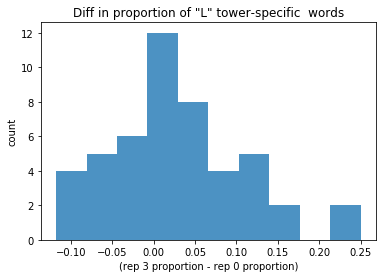

In [60]:
data = diffs

# fixed bin size

plt.hist(data, alpha=0.8)
plt.title('Diff in proportion of "L" tower-specific  words')
plt.xlabel('(rep 3 proportion - rep 0 proportion)')
plt.ylabel('count')

plt.show()

In [24]:
s = df_intersection[df_intersection['repNum'] == 3]['tower_specific_words']
l = [element for list_ in s for element in list_]
counts = Counter(l)
print(len(counts.keys()))
counts.most_common()[:5]


53


[('C', 13), ('blue', 4), ('red', 4), ('third', 3), ('top', 3)]

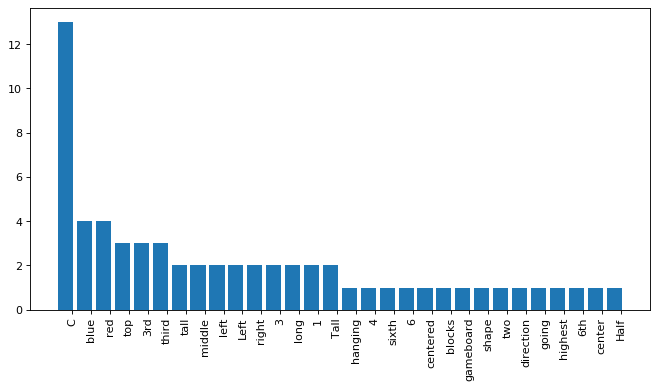

In [25]:
labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
x_limit = 30

# rearrange your data
labels = np.array(labels)[indSort][:x_limit]
values = np.array(values)[indSort][:x_limit]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels,  rotation='vertical')
plt.show()